## LSTM Close Price Prediction

In [1]:
%matplotlib inline

In [2]:
import sys
assert sys.version_info >= (3, 5)



In [57]:
import os

In [3]:
from ml_analysis import MLOperator, MLEvaluator

In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
from sklearn.metrics import f1_score

In [10]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras

import sklearn
assert sklearn.__version__ >= "0.20"


In [54]:
PROJECT_ROOT_PATH = '/home/arto/git/Dixon_LSTM/work'

Loading the Pandas Dataframe, viewing the first ten rows and the distribution of the labels:

In [11]:
df = pd.read_csv('data/HFT.csv')

In [12]:
df.head()

,feature_1,feature_2,feature_3,label
0,0.515301,0.72,0.710953,0
1,0.515301,0.72,0.710953,0
2,0.515301,0.72,0.710953,0
3,0.515301,0.72,0.710953,0
4,0.515301,0.72,0.710953,0


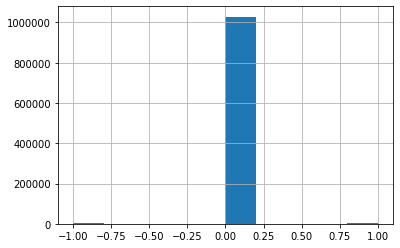

In [13]:
df.label.hist()

In [14]:
df.label.value_counts()

 0    1028280
 1       2629
-1       2623
Name: label, dtype: int64

We observe that there is a class imbalance problem. Proceeding without correcting for the imbalance will lead to spurious results. 

Our exposition includes examples of exploratory data analysis, designed to provide intuition into the level of non-linearity in the map $Y=F(X)$. Let's first view the distribution of our features by each label 0,-1, then 1. 

*Note: We just consider feature_1, but you should check the other features too.*

0


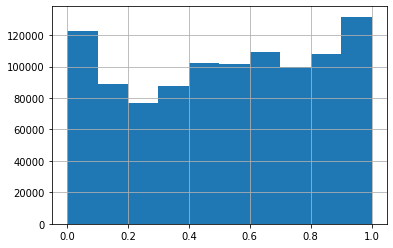

-1


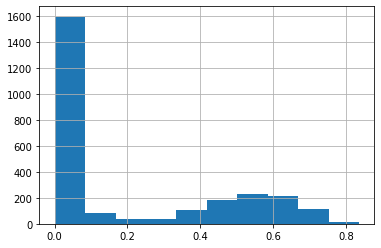

1


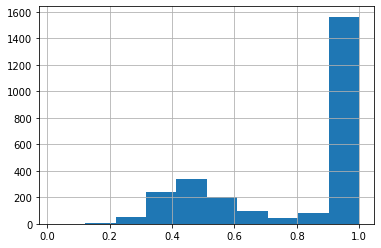

In [15]:
for lab in df.label.unique():
    print(lab)
    df.feature_1[df.label==lab].hist()
    plt.show()
    plt.close()

### Preparation of the training and testing sets

We use a simple 80/20 splitting rule, ensuring that the training set pre-dates the testing set (to avoid look-ahead bias).

In [16]:
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df[:split]
df_test = df[split:]

Let's instantiate our MLOperator class which will be used for performing high-level data processing tasks on top of Keras.

In [17]:
operator = MLOperator()

### Sampling

**Training Set**: Resolve the time series class imbalance problem by sampling in a neighborhood of the up and down ticks. We choose this neighborhood to be a lagging window of size 20. Although simplistic, this preserves at least some of the covariance structure in the time series data.

**Testing Set**: Do not sample - leave imbalanced.

In [18]:
n_steps = 20
use_features = ['feature_1']
y_train = df_train.label

In [19]:
sampled_idx = operator.get_samples_index(y_train.iloc[n_steps-1:], 'min')

In [20]:
x_train = df_train[use_features]
y_test = df_test.label.iloc[n_steps-1:]
x_test = df_test[use_features]

### Data formatting for LSTMs

Let's define the following function for reshaping the data into times series classification format. For example, consider a univariate time series of increasing integers

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15

In [31]:
def get_LSTM_data(x_train, y_train, x_test, y_test, sampled_idx, n_steps):
    # training set
    x_train_m = x_train.values
    x_train_list = []
    for idx in sampled_idx:
        int_idx = y_train.index.get_loc(idx)
        x_train_list.append(x_train_m[(int_idx-n_steps+1):int_idx+1])

    x_train = np.array(x_train_list)
    y_train = pd.get_dummies(y_train[sampled_idx]).values

    # test set
    x_test_m = x_test.values
    x_test_list = []
    for i in range(x_test.shape[0] - n_steps+1):
        x_test_list.append(x_test_m[i: (i + n_steps)])
    x_test = np.array(x_test_list)

    y_test = pd.get_dummies(y_test).values
    
    return x_train, y_train, x_test, y_test

In [32]:
x_train, y_train, x_test, y_test = get_LSTM_data(x_train, y_train, x_test, y_test, sampled_idx, n_steps)

In [33]:
nrow = 3000
x_valid = x_test[0:nrow]
y_valid = y_test[0:nrow]
x_test = x_test[nrow:]
y_test = y_test[nrow:]

In [34]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape, x_valid.shape, y_valid.shape)

(6294, 20, 1) (6294, 3) (200688, 20, 1) (200688, 3) (3000, 20, 1) (3000, 3)


## LSTM Model Specification

We now proceed with the model specification in Keras. Consistent with the window size, we specify a ten layer LSTM network and squash each unit output with a softmax function.

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(10, stateful=False, input_shape=(x_train.shape[1], x_train.shape[-1])))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

In [37]:
# Configurations
initial_lrate = 0.0001

In [40]:
adagrad = keras.optimizers.Adagrad(lr=initial_lrate, epsilon=1e-08, decay=0.0)
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [41]:
callbacks_list = list()

In [42]:
# learning rate schedule
# LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)
# Or: decrease half of the learning rate after every epochs_drop (20 epochs for example)
def step_decay(epoch):
    lrate = initial_lrate
    epochs_drop = 70
    drop = 0.5
    if (epoch % epochs_drop == 0):
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        print("Decreased Learning Rate to: {}".format(lrate))
    return lrate

In [45]:
lrate = keras.callbacks.LearningRateScheduler(step_decay)

In [46]:
callbacks_list.append(lrate)

In [47]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [48]:
# initial settings
n_epoch = 20
n_batch = 500
last_epoch_th = 0

In [49]:
%%time
history = model.fit(x_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=1,
          validation_data=(x_valid, y_valid), shuffle=True, callbacks = callbacks_list, 
                    initial_epoch = last_epoch_th)

Train on 6294 samples, validate on 3000 samples
Decreased Learning Rate to: 0.0001
Epoch 1/20
6294/6294 [==============================] - 4s 709us/sample - loss: 1.0707 - accuracy: 0.3379 - val_loss: 1.1234 - val_accuracy: 0.0153
Epoch 2/20
6294/6294 [==============================] - 1s 108us/sample - loss: 1.0684 - accuracy: 0.3557 - val_loss: 1.1200 - val_accuracy: 0.0300
Epoch 3/20
6294/6294 [==============================] - 1s 130us/sample - loss: 1.0660 - accuracy: 0.3743 - val_loss: 1.1164 - val_accuracy: 0.0433
Epoch 4/20
6294/6294 [==============================] - 1s 144us/sample - loss: 1.0637 - accuracy: 0.3901 - val_loss: 1.1127 - val_accuracy: 0.0800
Epoch 5/20
6294/6294 [==============================] - 1s 124us/sample - loss: 1.0614 - accuracy: 0.4126 - val_loss: 1.1096 - val_accuracy: 0.0933
Epoch 6/20
6294/6294 [==============================] - 1s 150us/sample - loss: 1.0590 - accuracy: 0.4347 - val_loss: 1.1061 - val_accuracy: 0.0973
Epoch 7/20
6294/6294 [=======

### Serialization
If no further adjustments to the training are needed then we can save the model to HDF5 format and simply reload it in future notebook sessions. 

In [58]:
# save the model
model_path = os.path.join(PROJECT_ROOT_PATH, 'model_lstm.hdf5')
model.save(model_path, overwrite=True)  # creates a HDF5 file 'my_model.h5'

In [59]:
hist = history.history

In [61]:
history_path = os.path.join(PROJECT_ROOT_PATH, 'history')

np.save(history_path, hist)



## Prediction

In [62]:
# returns a compiled model
# identical to the previous one
model = load_model('model/lstm.hdf5')

NameError: name 'load_model' is not defined

In [52]:
%%time
pred_df_train, pred_df_test, _ = operator.get_pred_dfs(x_train, x_test, y_train, y_test, 
                                                       classifier='tensorflow', model=model, 
                                                       columns=['-1', '0', '1'])

CPU times: user 57.3 s, sys: 1min 3s, total: 2min 1s
Wall time: 31.2 s


In [53]:
train_f1 = f1_score(pred_df_train.true, pred_df_train.predict, average=None)
test_f1 = f1_score(pred_df_test.true, pred_df_test.predict, average=None)
print(train_f1)
print(test_f1)

[0.66597132 0.15426997 0.63329041]
[0.02127738 0.16353439 0.00586791]


## Model Evaluation

We instantiate our MLEvaluator class to store the performance results of the classifier.

In [63]:
evaluator = MLEvaluator()

In [64]:
evaluator.set_pred_df(pred_df_train)
cf_mx_train = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_train.values(), [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_train.values(), [-1, 0, 1], 
    normalize=True)
fig = evaluator.plot_roc()

AttributeError: 'MLEvaluator' object has no attribute 'plot_confusion_matrix'

In [65]:
evaluator.set_pred_df(pred_df_test)
cf_mx_test = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_test.values(), [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_test.values(), [-1, 0, 1], 
    normalize=True)
fig = evaluator.plot_roc()

AttributeError: 'MLEvaluator' object has no attribute 'plot_confusion_matrix'

##  Learning Curves

We seek to evaluate the bias-variance tradeoff as a function of the size of the training set. This can address the question of whether the sample size is 'sufficient' for our classifier - we expect the performance on the test set to converge to that on the training set with increasing sample size.

In [66]:
y_train_bvt = df_train.label
x_train_bvt = df_train[use_features]
y_test_bvt = df_test.label.iloc[n_steps-1:]
x_test_bvt = df_test[use_features]

In [68]:
n_exp = 1
n_obs_list = range(100, int(len(sampled_idx)/3), 300)
print(n_obs_list)

# initial settings
n_epoch = 20
n_batch = 500
last_epoch_th = 0

range(100, 2098, 300)


In [69]:
f1_df_list = []

In [70]:
bvt_callbacks_list = list()
bvt_callbacks_list.append(lrate)

In [71]:
for exp in range(n_exp):
    print('experiment ', exp)
    for n_obs in n_obs_list:
        print('number of observations ', n_obs)
        sampled_idx_sm = operator.get_samples_index(y_train_bvt.iloc[n_steps-1:], n_obs)
        print(len(sampled_idx_sm))
        
        x_train_sm, y_train_sm, x_test_sm, y_test_sm = get_LSTM_data(x_train_bvt, y_train_bvt, x_test_bvt, y_test_bvt, 
                                                                     sampled_idx_sm, n_steps)
        
        print(x_train_sm.shape,y_train_sm.shape,x_test_sm.shape,y_test_sm.shape)

        model.fit(x_train_sm, y_train_sm, epochs=n_epoch, batch_size=n_batch, verbose=2,
                    shuffle=True, callbacks = bvt_callbacks_list, 
                    initial_epoch = last_epoch_th)
        
        pred_df_train, pred_df_test, _ = operator.get_pred_dfs(x_train_sm, x_test_sm, y_train_sm, y_test_sm, 
                                                       classifier='tensorflow', model=model, 
                                                       columns=['-1', '0', '1'])
        
        train_f1 = f1_score(pred_df_train.true, pred_df_train.predict, average=None)
        test_f1 = f1_score(pred_df_test.true, pred_df_test.predict, average=None)

        f1_df = pd.DataFrame([train_f1, test_f1])
        f1_df.columns = ['-1', '0', '1']
        f1_df.index = ['train', 'test']
        f1_df['n_obs'] = n_obs * 3
        f1_df_list.append(f1_df)

experiment  0
number of observations  100
300
(300, 20, 1) (300, 3) (206688, 20, 1) (206688, 3)
Train on 300 samples
Decreased Learning Rate to: 0.0001
Epoch 1/20
300/300 - 0s - loss: 1.0129 - accuracy: 0.5600
Epoch 2/20
300/300 - 0s - loss: 1.0127 - accuracy: 0.5600
Epoch 3/20
300/300 - 0s - loss: 1.0124 - accuracy: 0.5600
Epoch 4/20
300/300 - 0s - loss: 1.0121 - accuracy: 0.5600
Epoch 5/20
300/300 - 0s - loss: 1.0119 - accuracy: 0.5633
Epoch 6/20
300/300 - 0s - loss: 1.0116 - accuracy: 0.5567
Epoch 7/20
300/300 - 0s - loss: 1.0113 - accuracy: 0.5567
Epoch 8/20
300/300 - 0s - loss: 1.0110 - accuracy: 0.5567
Epoch 9/20
300/300 - 0s - loss: 1.0107 - accuracy: 0.5567
Epoch 10/20
300/300 - 0s - loss: 1.0105 - accuracy: 0.5567
Epoch 11/20
300/300 - 0s - loss: 1.0102 - accuracy: 0.5567
Epoch 12/20
300/300 - 0s - loss: 1.0099 - accuracy: 0.5567
Epoch 13/20
300/300 - 0s - loss: 1.0096 - accuracy: 0.5567
Epoch 14/20
300/300 - 0s - loss: 1.0093 - accuracy: 0.5567
Epoch 15/20
300/300 - 0s - loss

5700/5700 - 0s - loss: 0.8906 - accuracy: 0.6147
Epoch 2/20
5700/5700 - 0s - loss: 0.8888 - accuracy: 0.6184
Epoch 3/20
5700/5700 - 0s - loss: 0.8871 - accuracy: 0.6195
Epoch 4/20
5700/5700 - 0s - loss: 0.8853 - accuracy: 0.6202
Epoch 5/20
5700/5700 - 0s - loss: 0.8835 - accuracy: 0.6212
Epoch 6/20
5700/5700 - 0s - loss: 0.8818 - accuracy: 0.6239
Epoch 7/20
5700/5700 - 0s - loss: 0.8800 - accuracy: 0.6246
Epoch 8/20
5700/5700 - 0s - loss: 0.8783 - accuracy: 0.6249
Epoch 9/20
5700/5700 - 0s - loss: 0.8766 - accuracy: 0.6282
Epoch 10/20
5700/5700 - 0s - loss: 0.8748 - accuracy: 0.6281
Epoch 11/20
5700/5700 - 1s - loss: 0.8731 - accuracy: 0.6291
Epoch 12/20
5700/5700 - 0s - loss: 0.8714 - accuracy: 0.6307
Epoch 13/20
5700/5700 - 0s - loss: 0.8696 - accuracy: 0.6321
Epoch 14/20
5700/5700 - 0s - loss: 0.8680 - accuracy: 0.6318
Epoch 15/20
5700/5700 - 0s - loss: 0.8663 - accuracy: 0.6318
Epoch 16/20
5700/5700 - 0s - loss: 0.8647 - accuracy: 0.6311
Epoch 17/20
5700/5700 - 0s - loss: 0.8630 - 

In [72]:
final_f1_df = pd.concat(f1_df_list)

In [73]:
final_f1_df.to_csv('history/lstm_bias_variance.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'history/lstm_bias_variance.csv'

In [ ]:
final_f1_df = pd.read_csv('history/lstm_bias_variance.csv', index_col=0)

In [ ]:
final_f1_df['macro_avg'] = final_f1_df[['-1','0','1']].mean(axis=1)

In [ ]:
for label in ['macro_avg', '1', '0', '-1']:
    evaluator.plot_learning_curve(final_f1_df, label, 'n_obs')

## Loss function convergence 

In [ ]:
history_path = "history/lstm_history.json"
with open(history_path, 'r') as fp:
    hist = json.load(fp)

In [ ]:
fig = plt.figure(figsize=(6, 4.5))
train_line = plt.plot(range(len(hist['acc'])), hist["acc"],  color="b", label="Training")
vald_line = plt.plot(range(len(hist['acc'])), hist["val_acc"], color="g", label="Validattion")
plt.legend(loc="best", fontsize=15)
plt.ylim(-0.1, 1)
plt.title("accuracy vs epoch")
plt.xlabel('epoch', fontsize=20)
plt.ylabel('score', fontsize=20)

In [ ]:
fig = plt.figure(figsize=(6, 4.5))
train_line = plt.plot(range(len(hist['loss'])), hist["loss"],  color="b", label="Training")
vald_line = plt.plot(range(len(hist['loss'])), hist["val_loss"], color="g", label="Validattion")
plt.legend(loc="best", fontsize=15)
plt.title("loss vs epoch")
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)

## LSTM Model Regression

An alternative approach to classification is to formulate the response as a continuous variable and predict the 'smart price' as a uni-variate time series. The smart price is the volume weighted mid-price, represented by feature_3 in our dataset.

### Data formatting

In [74]:
use_features = ['feature_3']
target = 'feature_3'
n_steps = 10

In [75]:
train_weight = 0.8
split = int(len(df)*train_weight)

In [76]:
df_train = df.iloc[:split]
std_df_train = df_train[use_features].apply(lambda x: (x - x.mean()) / x.std())
df_test = df.iloc[split:]
std_df_test = df[use_features].apply(lambda x: (x - x.mean()) / x.std()).iloc[split:]

In [77]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [78]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(std_df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

In [79]:
col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

In [82]:
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [83]:
x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(std_df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

In [87]:
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [88]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(826815, 10, 1) (826815, 1) (206697, 10, 1) (206697, 1)


### Model Specification

In [90]:
reg_model = keras.models.Sequential()
reg_model.add(keras.layers.LSTM(10, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
reg_model.add(keras.layers.Dense(1))
reg_model.compile(loss='mean_squared_error', optimizer='adam')

In [91]:
last_epoch_th = 0

In [92]:
reg_model.fit(x_train_reg, y_train_reg, epochs=20, batch_size=500, verbose=1, initial_epoch = last_epoch_th)

Train on 826815 samples
Epoch 1/20
826815/826815 [==============================] - 36s 43us/sample - loss: 0.0097
Epoch 2/20
826815/826815 [==============================] - 32s 38us/sample - loss: 4.6313e-05
Epoch 3/20
826815/826815 [==============================] - 33s 39us/sample - loss: 2.8783e-05
Epoch 4/20
826815/826815 [==============================] - 32s 39us/sample - loss: 2.1927e-05
Epoch 5/20
826815/826815 [==============================] - 33s 39us/sample - loss: 1.9534e-05
Epoch 6/20
 68000/826815 [=>............................] - ETA: 38s - loss: 1.9454e-05

KeyboardInterrupt: 

In [ ]:
# save the model
reg_model.save('model/lstm_regression_HFT.hdf5', overwrite=True)  # creates a HDF5 file 'my_model.h5'

In [ ]:
# returns a compiled model
# identical to the previous one
reg_model = load_model('model/lstm_regression_HFT.hdf5')

### Prediction

In [93]:
%%time
# make predictions
pred_train = reg_model.predict(x_train_reg, verbose=1)
pred_test = reg_model.predict(x_test_reg, verbose=1)

213344/826815 [======>.......................] - ETA: 54s

KeyboardInterrupt: 

### Plotting the model output

NameError: name 'pred_train' is not defined

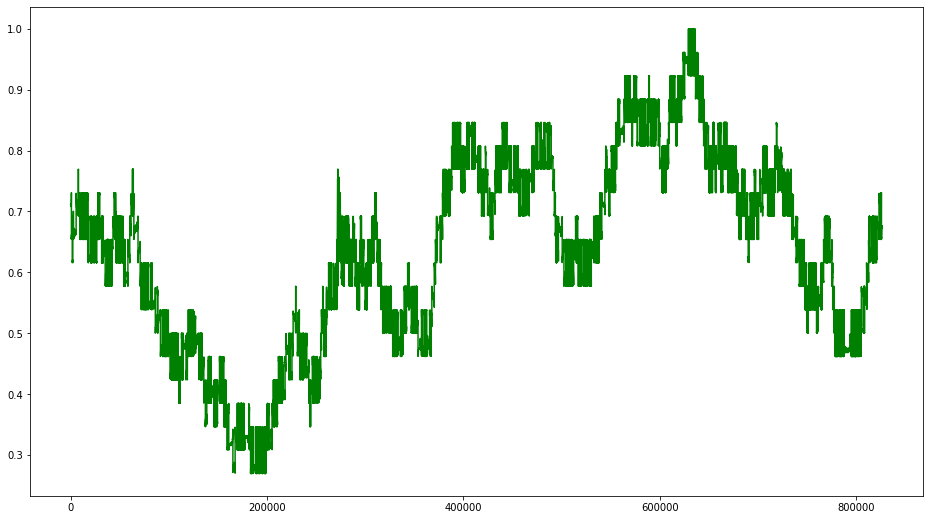

In [94]:
fig = plt.figure(figsize=(16,9))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="g", label="Real (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], pred_train[:, 0], color="r", label="Predict (Training)")
plt.legend(loc="best", fontsize=15)
plt.title('Real vs Predict (Training)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Data', fontsize=20)


fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="c", label="Real (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], pred_test[:, 0], color="m", label="Predict (Testing)")
plt.legend(loc="best", fontsize=15)
plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Data', fontsize=20)

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# calculate root mean squared error
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], pred_test[:, 0])
print(MSE_test)